# Project Planning Stage, Methods, and Code

Name: Anthony Leong (69730208)

## Data Description

The dataset is a comprehensive catalogue of Airbnb listings in some popular European cities, such as London, Rome, and Budapest. In total, the dataset contains the complete information of 51,708 Airbnb listings, with 9,993, 9,027, and 4,022 of those listings coming from the cities of interest London, Rome, and Budapest respectively. The data was collected using Airbnb to obtain the information for each listing, TripAdvisor to obtain reviews of nearby attractions/restaurants, and Wikipedia to calculate the distance to the nearest metro station (Gyódi & Nawaro, 2021).

Variables:
- `id`: The id of the listing (numeric)
- `realSum`: The total price of the listing for two people and two nights in EUR (numeric)
- `room_type`: The type of listing - the entire home/apartment, a private room, or a shared room (categorical, 3 levels)
- `room_shared`: Indicates whether the listing is for a shared room (categorical, binary)
- `room_private`: Indicates whether the listing is for a private room (categorical, binary)
- `person_capacity`: The maximum capacity of the listing (numeric)
- `host_is_superhost`: Indicates whether the host of the listing is a superhost (categorical, binary)
- `multi`: Indicates whether the listing is from a host with 2-4 listings (categorical, binary)
- `biz`: Indicates whether the listing is from a host with more than 4 listings (categorical, binary)
- `cleanliness_rating`: The rating of the listing's cleanliness (numeric)
- `guest_satisfaction_overall`: The overall satisfaction rating of the listing (numeric)
- `bedrooms`: The total number of bedrooms (numeric)
- `dist`: The distance from the listing to the city centre in km (numeric)
- `metro_dist`: The distance from the listing to the nearest metro station in km (numeric)
- `attr_index`: The attraction index of the listing location, determined by the number of reviews at nearby attractions (numeric)
- `attr_index_norm`: The normalized attraction index, range 0 to 100 (numeric)
- `rest_index`: The restaurant index of the listing location, determined by the number of reviews at nearby restaurants (numeric)
- `rest_index_norm`: The normalized restaurant index, range 0 to 100 (numeric)
- `lng`: The longitude of the listing (numeric)
- `lat`: The latitude of the listing (numeric)
- `city`: The city where the listing is located (categorical, 10 levels)
- `weekend`: Indicates whether the listing is on a weekend (categorical, binary)

#### Pre-selection of Variables

The following variables/observations will be dropped:
- All information related to the type of room is contained within the `room_type` variable, so `room_shared` and `room_private` are redundant. Since those dummy variables can be created directly from `room_type`, `room_shared` and `room_private` will not be needed.
- The `id` variable is simply a unique identifier for each listing, thus `id` is a meaningless variable to analyze and will be dropped.
- Since the cities of interest are only London, Rome, and Budapest, observations (listings) that do not come from one of those three cities will be dropped.

## Question

The statistical question that will be answered is:

- How is the price of a listing associated with its maximum capacity and number of bedrooms? Are these associations different between London, Rome, and Budapest?

This is an inferential question with `realSum` as the response variable and with `person_capacity`, `bedrooms`, and `city` as predictors of interest. To avoid potential confounding, variable selection will be performed using all available variables in the dataset, not just the predictors of interest. Excessive interaction terms could result in an overly complicated model, so for the sake of simplicity, the only interaction terms that will be included in the model are: 

- Between `person_capacity` and `city` 
- Between `bedrooms` and `city`

## Exploratory Data Analysis and Visualization

In [1]:
#loading packages

#install.packages("MASS")
#install.packages("httr")
#install.packages("ggridges")
#install.packages("car")
#install.packages("rsample")
#install.packages("glmnet")
#install.packages("cowplot")
#install.packages("broom")
#install.packages("tidyverse")
library(MASS)
library(httr)
library(ggridges)
library(car)
library(rsample)
library(glmnet)
library(cowplot)
library(broom)
library(tidyverse)
options(repr.matrix.max.rows = 8)

Warning message:
"package 'MASS' was built under R version 4.4.3"
Warning message:
"package 'httr' was built under R version 4.4.3"
Warning message:
"package 'ggridges' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'rsample' was built under R version 4.4.3"
Warning message:
"package 'glmnet' was built under R version 4.4.3"
Loading required package: Matrix

Loaded glmnet 4.1-8

Warning message:
"package 'tidyverse' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()    masks Matrix::expand()
✖ dplyr::filter()    masks stat

In [2]:
#loading in data for london, rome, and budapest listings from the web
url1 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/london_weekdays.csv'
url2 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/london_weekends.csv'
url3 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/rome_weekdays.csv'
url4 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/rome_weekends.csv'
url5 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/budapest_weekdays.csv'
url6 <- 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/airbnb-prices-in-european-cities/budapest_weekends.csv'

download <- function(url) {
    temp <- tempfile(fileext = '.csv')
    GET(url, write_disk(temp))
    data <- read_delim(temp, skip = 0, delim = ",") |>
                dplyr::select(-c(1, room_shared, room_private))
    return(data)
}

london_day <- download(url1)
london_end <- download(url2)
rome_day <- download(url3)
rome_end <- download(url4)
budapest_day <- download(url5)
budapest_end <- download(url6)

New names:
• `` -> `...1`
Rows: 4614 Columns: 20
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 5379 Columns: 20
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:

In [3]:
#helper function that manually creates the city and weekend variables, also drops any observations with missing values
add_vars <- function(data, city, weekend) {
    data <- mutate(data, 
                   "city" = city,
                   "weekend" = weekend) |>
            drop_na() 
    return(data)
}

#combining into one dataset
london_day_vars <- add_vars(london_day, "London", 0)
london_end_vars <- add_vars(london_end, "London", 1)
rome_day_vars <- add_vars(rome_day, "Rome", 0)
rome_end_vars <- add_vars(rome_end, "Rome", 1)
budapest_day_vars <- add_vars(budapest_day, "Budapest", 0)
budapest_end_vars <- add_vars(budapest_end, "Budapest", 1)
airbnb <- bind_rows(london_day_vars, london_end_vars, rome_day_vars, rome_end_vars, budapest_day_vars, budapest_end_vars)

#splitting data into two sets - one for variable selection and another for inference
set.seed(9999)
airbnb_split <- initial_split(airbnb, prop = 0.6, strata = city)
airbnb_selection <- training(airbnb_split)
airbnb_inference <- testing(airbnb_split)
airbnb_selection

realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
<dbl>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
238.9905,Entire home/apt,6,TRUE,0,1,10,99,1,0.3593550,0.3526430,404.4047,24.116552,893.4773,67.65685,19.05074,47.50076,Budapest,0
300.7943,Entire home/apt,6,FALSE,0,1,9,98,2,0.9294272,0.2002355,1676.8760,100.000000,452.5397,34.26770,19.04493,47.50405,Budapest,0
162.3819,Entire home/apt,4,TRUE,0,0,10,98,1,2.4508403,0.2794518,163.5885,9.755551,191.9923,14.53825,19.02170,47.49882,Budapest,0
118.4377,Entire home/apt,2,FALSE,0,0,9,92,1,1.5594494,0.4779711,191.7198,11.433155,326.2156,24.70205,19.06301,47.51126,Budapest,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
601.0801,Entire home/apt,2,FALSE,0,1,10,92,1,1.978217,0.2779185,777.7236,17.23081,1979.2231,43.12247,12.47957,41.90636,Rome,1
582.3767,Entire home/apt,6,TRUE,0,1,10,96,2,3.124166,1.9395050,540.3414,11.97150,1985.4354,43.25782,12.46700,41.89100,Rome,1
447.2448,Entire home/apt,4,TRUE,1,0,10,98,1,1.641598,0.8588370,1125.8572,24.94387,1687.8958,36.77516,12.48342,41.89634,Rome,1
265.8219,Entire home/apt,6,FALSE,0,1,10,96,2,4.411877,0.3524935,167.7019,3.71551,467.3403,10.18221,12.53000,41.86700,Rome,1


Since `bedrooms`, `person_capacity`, and `city` are the predictors of interest, visualizing the distribution of `realSum` against each predictor allows preliminary assessments to be made on the strength of these associations and also provides a way to identify potential violations of assumptions. At this stage, it is especially important to assess assumptions such as linearity (between the response and the predictors) and homoscedasticity, as this information will help determine if certain steps need to be taken in order to apply the desired methods.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 10 rows containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 8 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 8 rows containing non-finite outside the scale range (`stat_ydensity()`)."


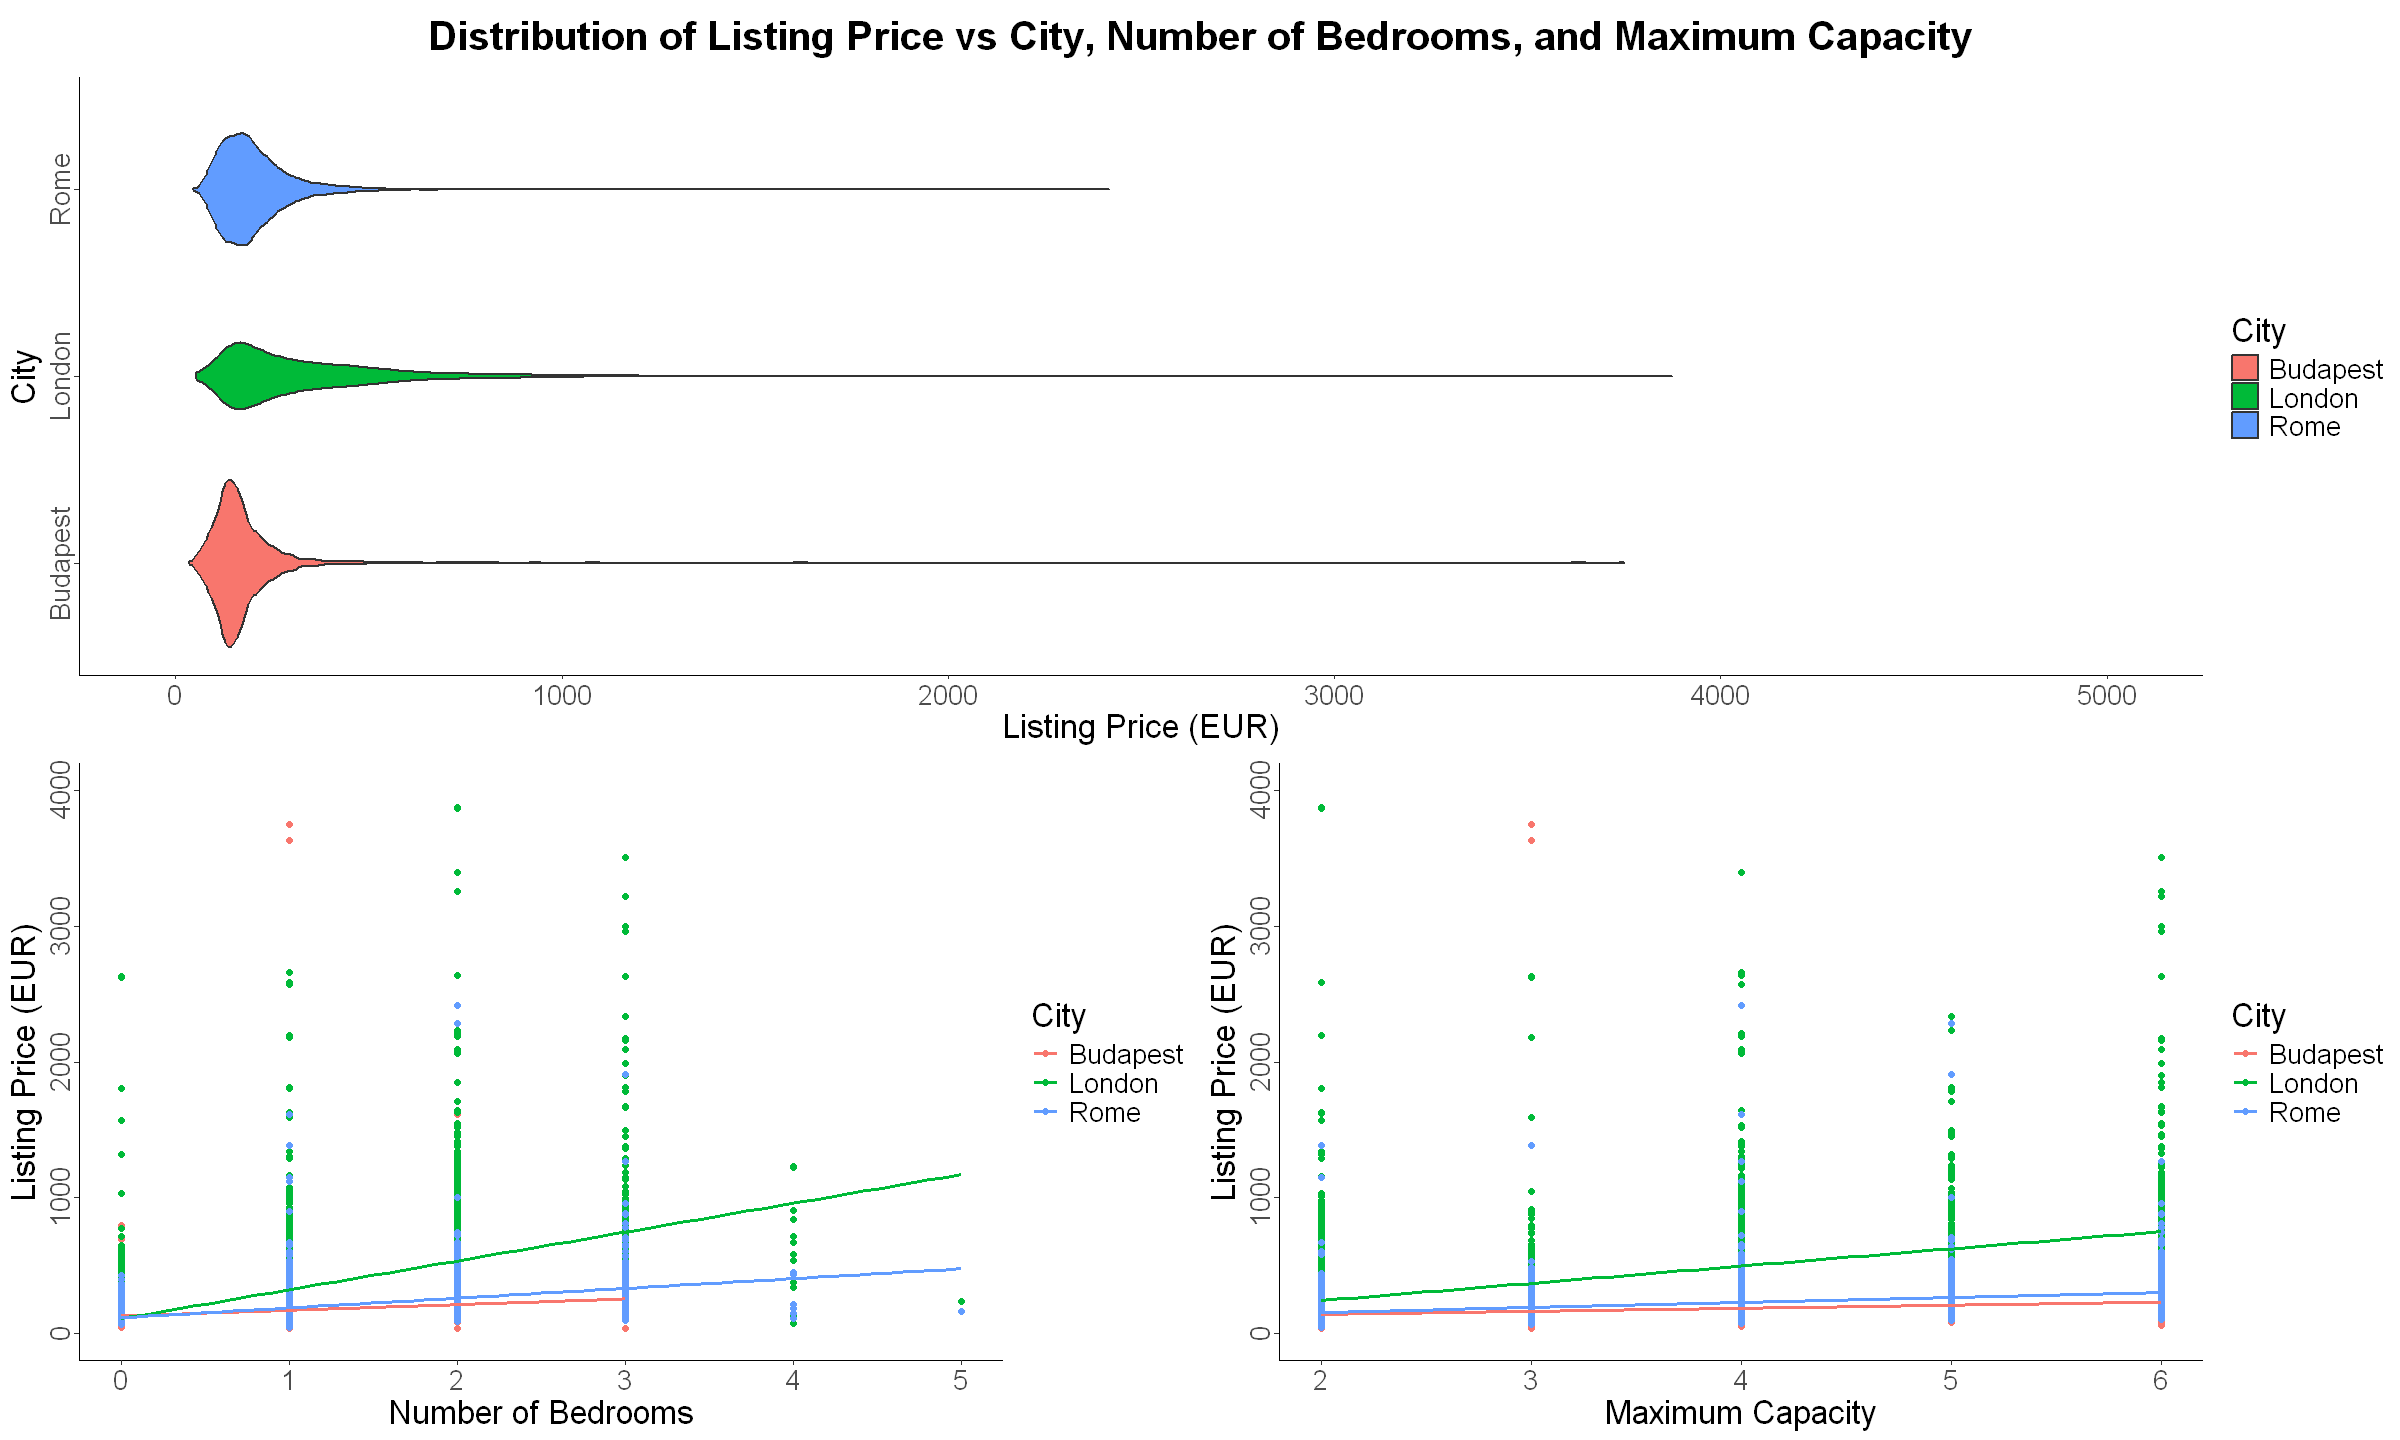

In [4]:
#title
title <- ggdraw() + draw_label("Distribution of Listing Price vs City, Number of Bedrooms, and Maximum Capacity", fontface = "bold", size = 24)

#distribution of listing price by city
options(repr.plot.width = 20, repr.plot.height = 10)
city_plot <- airbnb_selection |> 
    ggplot() + 
    geom_violin(aes(x = realSum, y = city, fill = city), linewidth = 0.7) + 
    theme(text = element_text(size = 20),
          panel.background = element_rect(fill = "white"),
          axis.line.x.top = element_blank(),
          axis.line.y.right = element_blank(),
          axis.line.x.bottom = element_line(),
          axis.line.y.left = element_line(),
          axis.text.y = element_text(angle = 90, hjust = 0.5)) +
    labs(x = "Listing Price (EUR)", y = "City", fill = "City") +
    xlim(c(0, 5000))

#scatterplot of listing price vs number of bedrooms
options(repr.plot.width = 10, repr.plot.height = 6)
bedroom_plot <- airbnb_selection |>
    ggplot(aes(x = bedrooms, y = realSum)) +
    geom_point(aes(colour = city)) + 
    geom_smooth(method = lm, se = FALSE, aes(colour = city)) + 
    theme(text = element_text(size = 20),
          panel.background = element_rect(fill = "white"),
          axis.line.x.top = element_blank(),
          axis.line.y.right = element_blank(),
          axis.line.x.bottom = element_line(),
          axis.line.y.left = element_line(),
          axis.text.y = element_text(angle = 90, hjust = 0.5)) +
    labs(x = "Number of Bedrooms", y = "Listing Price (EUR)", colour = "City") + 
    ylim(c(0, 4000)) + 
    xlim(c(0,5))

#scatterplot of listing price vs maximum capacity
capacity_plot <- airbnb_selection |>
    ggplot(aes(x = person_capacity, y = realSum)) +
    geom_point(aes(colour = city)) + 
    geom_smooth(method = lm, se = FALSE, aes(colour = city)) + 
    theme(text = element_text(size = 20),
          panel.background = element_rect(fill = "white"),
          axis.line.x.top = element_blank(),
          axis.line.y.right = element_blank(),
          axis.line.x.bottom = element_line(),
          axis.line.y.left = element_line(),
          axis.text.y = element_text(angle = 90, hjust = 0.5)) +
    labs(x = "Maximum Capacity", y = "Listing Price (EUR)", colour = "City") + 
    ylim(c(0, 4000))

#combining into a single plot
options(repr.plot.width = 20, repr.plot.height = 12)
plot_grid(title, city_plot, plot_grid(bedroom_plot, capacity_plot, ncol = 2, nrow = 1), ncol = 1, rel_heights = c(0.1, 1, 1))

**Figure 1.** Plots showing the distribution of listing prices against number of bedrooms (bottom left), maximum capacity (bottom right), and city (top). The lines in both scatterplots represent the result of regressing listing price on the x-axis predictor and `city` with interaction. All three plots were generated using only the dataset designated for variable selection. The range of some variables were truncated for visual clarity.

From the plots, we can see that the distribution of listing prices for each city is heavily right skewed. Additionally, the distribution of listing prices for Rome and Budapest are very similar as both distributions have similar peaks and variances, whereas the distribution of listing prices for London has a peak that is similar to the other two cities but with a significantly greater variance. The association between listing price and `bedrooms` appears to be fairly similar between Rome and Budapest, but the association in London differs significantly compared to the other two cities. A similar pattern is observed in the association between listing price and `person_capacity`—Rome and Budapest have similar associations which differ greatly compared to the association found in London listings.

The large amount of data makes it difficult to see trends in the data and thus definitively judge whether assumptions are violated. While linearity (individually) between listing price and the two numerical predictors cannot be determined for certain, at the very least, the plots do not suggest a severe violation of the linearity assumption as neither scatterplot displays a clear pattern in the data. As for homoscedasticity, the variance of listing price seems to be somewhat constant for all values of `person_capacity`. On the other hand, the variance of listing price appears to decrease significantly for listings with four or more bedrooms, though this could be due to the vast majority of listings having less than four bedrooms and/or outliers inflating the perceived variance due to the large size of the dataset. Regardless, homoscedasticity is an assumption that will need to be monitored closely.

## Methods and Plan

Since the response variable is continuous with an unbounded range (at least for large positive values), multiple linear regression is the most appropriate method for modeling the relationship between listing price and the predictors of interest (`bedrooms`, `person_capacity`, and `city`). The coefficients obtained from multiple linear regression are easy to interpret, which makes it simple and straightforward to assess the association between listing price and each predictor. To ensure that the regression coefficients are unbiased, variable selection will be performed. Since there are many categorical variables and some interaction terms, the `stepAIC()` function will be used to perform (stepwise) variable selection since it evaluates the contribution of an entire variable as opposed to individual coefficients. Additionally, the dataset will need to be split to avoid the issue of using the same data to select variables and perform inference (this was done in earlier code).

The assumptions required to apply multiple linear regression are:
- A linear relationship between the response and the predictors
- Independent residuals
- Residuals follow a Normal distribution
- Equal variance of residuals (homoscedasticity)

A notable limitation of this method is that multicollinearity goes largely unaddressed. Given the large number of potential predictors, 18 in total, multicollinearity is very likely to be an issue to some degree. In the context of multiple linear regression and stepwise variable selection, the main approach to mitigate multicollinearity is to manually drop collinear variables before fitting the model, though this may be undesirable if collinear variables have theoretical importance. Additionally, the variables selected by `stepAIC()` will depend on the direction in which stepwise selection is performed. 

## Computational Code and Output

In [5]:
#full and null models
null_model <- lm(realSum ~ 1, data = airbnb_selection)
full_model <- lm(realSum ~ . + bedrooms:city + person_capacity:city, data = airbnb_selection)

In [6]:
#stepwise selection
n <- nrow(airbnb_selection)
MLR_model <- stepAIC(full_model, direction = "backward", scope = list(lower = null_model, upper = full_model), k = log(n), trace = 0)
summary(MLR_model)


Call:
lm(formula = realSum ~ room_type + person_capacity + bedrooms + 
    metro_dist + attr_index_norm + rest_index + rest_index_norm + 
    lng + city + bedrooms:city + person_capacity:city, data = airbnb_selection)

Residuals:
    Min      1Q  Median      3Q     Max 
 -908.1   -69.0   -18.2    34.1 12717.6 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 3.534e+03  1.084e+03   3.262 0.001111 ** 
room_typePrivate room      -1.119e+02  6.709e+00 -16.680  < 2e-16 ***
room_typeShared room       -1.438e+02  4.174e+01  -3.445 0.000572 ***
person_capacity             3.402e+00  5.758e+00   0.591 0.554661    
bedrooms                    3.552e+01  1.095e+01   3.243 0.001187 ** 
metro_dist                 -1.272e+01  2.930e+00  -4.341 1.43e-05 ***
attr_index_norm             6.118e+00  4.357e-01  14.043  < 2e-16 ***
rest_index                  5.074e-02  1.308e-02   3.879 0.000106 ***
rest_index_norm            -1.954e+00  4.3

In [7]:
#summary table
options(repr.matrix.max.rows = 16)
options(scipen = 1)
tidy(MLR_model, conf.level = 0.95, conf.int = TRUE) |> mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3533.9513,1083.5255,3.2615,0.0011,1410.0942,5657.8083
room_typePrivate room,-111.9132,6.7094,-16.6801,0.0000,-125.0646,-98.7619
room_typeShared room,-143.8235,41.7429,-3.4455,0.0006,-225.6452,-62.0018
person_capacity,3.4017,5.7577,0.5908,0.5547,-7.8842,14.6876
bedrooms,35.5169,10.9527,3.2428,0.0012,14.0481,56.9857
metro_dist,-12.7184,2.9299,-4.3409,0.0000,-18.4614,-6.9754
attr_index_norm,6.1182,0.4357,14.0431,0.0000,5.2642,6.9722
rest_index,0.0507,0.0131,3.8786,0.0001,0.0251,0.0764
rest_index_norm,-1.9543,0.4304,-4.5407,0.0000,-2.7979,-1.1107


**Table 1.** Table containing the estimate, standard error, test statistic, p-value, and confidence interval of each selected coefficient/variable.

Out of the eight regression coefficients that correspond to predictors of interest, the coefficients for `bedrooms`, `cityLondon`, `cityRome`, `bedrooms:cityLondon`, and `person_capacity:cityLondon` are statistically significant at the 95% significance level, whereas the coefficients for `person_capacity`, `bedrooms:cityRome`, and `person_capacity:cityRome` are not statistically significant at the 95% significance level. For the most part, these results align with what was observed in Figure 1, as two of the three estimated coefficients that compare Rome to Budapest are not statistically significant at the 95% significance level, while all three of the estimated coefficients that compare London to Budapest are statistically significant at the 95% significance level. However, these results are not completely as expected—multicollinearity seems to be an issue since the coefficients for the intercept, `cityLondon`, and `cityRome` have very large estimates and standard errors compared to the other coefficients. A quick theoretical analysis of the selected variables suggests that removing variables such as `lng` could help mitigate multicollinearity without losing relevant information, since the longitude of a listing is likely to be highly correlated with what city the listing is in.

## References

- Gyódi, K., & Nawaro, Ł. (2021). Determinants of Airbnb prices in European cities: A spatial econometrics approach. Tourism Management, 86, 104319. https://doi.org/10.1016/j.tourman.2021.104319